In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [6]:
# First try / Applying multiple regression on data from 2011

house_price = pd.read_csv('2011_purgeddata_avg.csv')

In [7]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Codes                   625 non-null    object 
 1   New Code                625 non-null    object 
 2   Borough                 625 non-null    object 
 3   Names                   625 non-null    object 
 4   2011                    625 non-null    int64  
 5   White                   625 non-null    int64  
 6   white_avg               625 non-null    float64
 7   Mixed                   625 non-null    int64  
 8   mix_avg                 625 non-null    float64
 9   Asian or Asian British  625 non-null    int64  
 10  asian_avg               625 non-null    float64
 11  Black or Black British  625 non-null    int64  
 12  black_avg               625 non-null    float64
 13  Other                   625 non-null    int64  
 14  oth_avg                 625 non-null    fl

In [8]:
house_price.head()

,Codes,New Code,Borough,Names,2011,White,white_avg,Mixed,mix_avg,Asian or Asian British,asian_avg,Black or Black British,black_avg,Other,oth_avg,2011.1
0,00AA,E09000001,City of London,City of London,7412,5799,0.7824,289,0.0390,940,0.1268,193,0.0260,154,0.0208,"465,000.0000"
1,00ABFX,E05000026,Barking and Dagenham,Abbey,13002,3596,0.2766,585,0.0450,5619,0.4322,2621,0.2016,365,0.0281,"177,000.0000"
2,00ABFY,E05000027,Barking and Dagenham,Alibon,10462,7275,0.6954,362,0.0346,743,0.0710,1900,0.1816,105,0.0100,"160,000.0000"
3,00ABFZ,E05000028,Barking and Dagenham,Becontree,11598,6789,0.5854,524,0.0452,2009,0.1732,2048,0.1766,175,0.0151,"170,000.0000"
4,00ABGA,E05000029,Barking and Dagenham,Chadwell Heath,10041,6224,0.6199,473,0.0471,1560,0.1554,1593,0.1586,171,0.0170,"195,000.0000"


In [9]:
house_price_final = house_price.drop(['Codes', 'New Code', 'Borough', 'Names', '2011', 'White', 
                                      'Mixed', 'Asian or Asian British', 'Black or Black British', 'Other'], axis=1)

# double check the result
house_price_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   white_avg  625 non-null    float64
 1   mix_avg    625 non-null    float64
 2   asian_avg  625 non-null    float64
 3   black_avg  625 non-null    float64
 4   oth_avg    625 non-null    float64
 5   2011.1     625 non-null    float64
dtypes: float64(6)
memory usage: 29.4 KB


In [10]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [11]:
# using VIF on the bike_rental dataset
df_predictors_selected_VIF = drop_column_using_vif_(house_price_final.drop('2011.1', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: white_avg
The columns remaining after VIF selection are:
Index(['mix_avg', 'asian_avg', 'black_avg', 'oth_avg'], dtype='object')


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [13]:
model_house_price = sm.OLS(endog=house_price_final[['2011.1']], 
                           exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_house_price.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 2011.1   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     99.47
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           2.20e-65
Time:                        16:56:50   Log-Likelihood:                -8224.1
No. Observations:                 625   AIC:                         1.646e+04
Df Residuals:                     620   BIC:                         1.648e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.745e+05   2.06e+04     13.353      0.000    2.34e+05    3.15e+05
mix_avg     3.003e+06    4.9e+05      6.133      0.000    2.04e+06    3.96e+06
asian_avg   -2.02e+05    3.6e+04     -5.607      0.000   -2.73e+05   -1.31e+05
black_avg  -1.074e+06    7.3e+04    -14.717      0.000   -1.22e+06   -9.31e+05
oth_avg     2.172e+06    2.2e+05      9.884      0.000    1.74e+06     2.6e+06
==============================================================================
Omnibus:                      475.501   Durbin-Watson:                   1.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10984.275
Skew:                           3.150   Prob(JB):                         0.00
Kurtosis:                      22.547   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

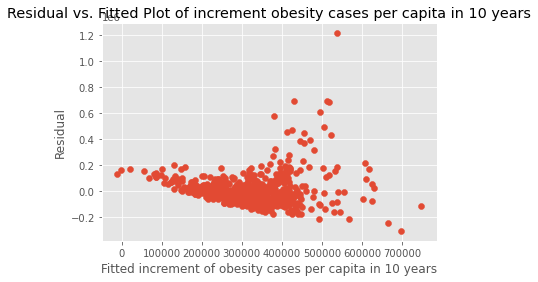

In [14]:
#Residual Analysis

# plot 
plt.scatter(model_house_price.fittedvalues, model_house_price.resid)
# adding title and labels
plt.xlabel('Fitted increment of obesity cases per capita in 10 years')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of increment obesity cases per capita in 10 years')
plt.show()